In [107]:
import pandas as pd
import numpy as np
from pycaret.regression import *

# Load your dataset
df = pd.read_csv("data_preprocess\export-pm25_eng-1h.csv", parse_dates=["timestamp"], index_col="timestamp")
df = df.sort_values(by="timestamp")
df.head()


,Unnamed: 0,timezone,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature
timestamp,,,,,,,
2023-03-31 22:00:00,0,Asia/Bangkok,62.659563,4.727273,4.727273,4.727273,27.147784
2023-04-02 18:00:00,1,Asia/Bangkok,69.995698,7.857143,7.142857,7.142857,32.246966
2023-04-02 19:00:00,2,Asia/Bangkok,65.608215,8.400000,7.800000,7.800000,32.518829
2023-04-02 20:00:00,3,Asia/Bangkok,65.489705,8.750000,8.266667,8.266667,31.864227
2023-04-02 21:00:00,4,Asia/Bangkok,65.811462,10.316667,9.083333,9.083333,31.412888


In [108]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)
df = df.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp", 'pm_10'], axis=1)

In [109]:
from scipy import stats
df = df[(np.abs(stats.zscore(df['humidity'])) < 3)]  # ลบค่าผิดปกติออก
df = df[(np.abs(stats.zscore(df['temperature'])) < 3)]  # ลบค่าผิดปกติออก
df = df[(np.abs(stats.zscore(df['pm_2_5'])) < 3)]  # ลบค่าผิดปกติออก
df

,humidity,pm_2_5,temperature,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,
2023-04-03 00:00:00,66.876119,7.200000,30.042084,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857,4.727273
2023-04-03 01:00:00,67.430725,7.783333,29.392181,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857
2023-04-03 02:00:00,68.017985,16.500000,29.118591,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000
2023-04-03 03:00:00,68.853455,24.783333,28.612701,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667
2023-04-03 04:00:00,69.691119,28.543860,28.313422,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333
...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,90.929747,37.568627,23.684319,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333


<Axes: ylabel='pm_2_5'>

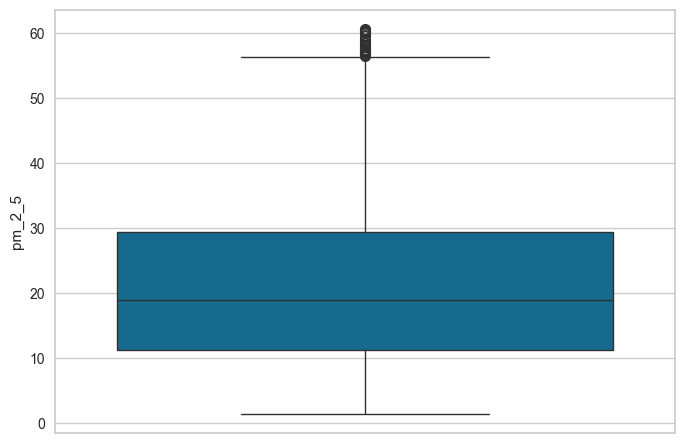

In [110]:
import seaborn as sns
sns.boxplot(df["pm_2_5"])  # Check for outliers

In [111]:
exp = setup(data=df, target='pm_2_5', fold=10, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(14310, 10)"
4,Transformed data shape,"(13809, 10)"
5,Transformed train set shape,"(9516, 10)"
6,Transformed test set shape,"(4293, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [112]:
best_model = compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,3.3947,25.1625,5.0126,0.8365,0.2830,0.2446,2.7100
lightgbm,Light Gradient Boosting Machine,3.4010,25.3495,5.0319,0.8354,0.2826,0.2408,1.4240
et,Extra Trees Regressor,3.4894,26.2658,5.1226,0.8294,0.2909,0.2527,0.5240
rf,Random Forest Regressor,3.4876,26.3238,5.1278,0.8290,0.2910,0.2514,1.3080
lr,Linear Regression,3.4057,26.4505,5.1376,0.8283,0.2868,0.2510,0.1850
ridge,Ridge Regression,3.4057,26.4505,5.1376,0.8283,0.2868,0.2510,0.1800
br,Bayesian Ridge,3.4062,26.4491,5.1375,0.8283,0.2869,0.2511,0.1810
en,Elastic Net,3.4355,26.5655,5.1496,0.8275,0.2885,0.2545,0.1850
lar,Least Angle Regression,3.4247,26.6862,5.1605,0.8268,0.2908,0.2536,0.1930
lasso,Lasso Regression,3.4515,26.7935,5.1718,0.8260,0.2889,0.2551,0.1830


In [114]:
predict_model(best_model,data=df)  # Train the best model on the entire dataset

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.2551,22.9542,4.7911,0.8520,0.2729,0.2342


,humidity,temperature,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,
2023-04-03 00:00:00,66.876122,30.042084,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,4.727273,7.200000,9.393748
2023-04-03 01:00:00,67.430725,29.392181,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,7.783333,9.331506
2023-04-03 02:00:00,68.017982,29.118591,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,16.500000,10.155488
2023-04-03 03:00:00,68.853455,28.612701,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,24.783333,18.344225
2023-04-03 04:00:00,69.691116,28.313421,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,28.543859,24.618806
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,90.929749,23.684319,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416666,37.568626,33.139931
2025-02-11 09:00:00,83.511566,25.896389,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,38.799999,37.282990
2025-02-11 10:00:00,72.046738,28.852625,38.799999,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,23.333334,36.236055


In [115]:
# Get the last row (most recent data point)
latest_data = df.iloc[-1:].copy()

# Shift lag features forward by 1 day
for lag in range(1, 8):
    latest_data[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].iloc[-lag]

# Make predictions
future_pred = predict_model(best_model, data=latest_data)
print(future_pred)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1563,0.0244,0.1563,nan,0.0071,0.0074


                      humidity  temperature  pm_2_5_lag_1  pm_2_5_lag_2  \
timestamp                                                                 
2025-02-11 11:15:36  61.046112    31.861471          21.0         21.85   

                     pm_2_5_lag_3  pm_2_5_lag_4  pm_2_5_lag_5  pm_2_5_lag_6  \
timestamp                                                                     
2025-02-11 11:15:36     23.333334     38.799999     37.568626     31.325581   

                     pm_2_5_lag_7  pm_2_5  prediction_label  
timestamp                                                    
2025-02-11 11:15:36     28.533333    21.0         20.843656  


**Test with other Data**
use data_preprocess\export-pm25_eng-1d.csv to test best_model

In [116]:
df_test = pd.read_csv("data_preprocess\export-pm25_eng-1d.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test = df_test.sort_values(by="timestamp")

In [117]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test[f'pm_2_5_lag_{lag}'] = df_test['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test.dropna(inplace=True)
df_test = df_test.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp", 'pm_10'], axis=1)

In [118]:
df_test = df_test[(np.abs(stats.zscore(df_test['humidity'])) < 3)]  # ลบค่าผิดปกติออก
df_test = df_test[(np.abs(stats.zscore(df_test['temperature'])) < 3)]  # ลบค่าผิดปกติออก
df_test = df_test[(np.abs(stats.zscore(df_test['pm_2_5'])) < 3)]  # ลบค่าผิดปกติออก

In [119]:
predict_df_test = predict_model(best_model, data=df_test)
predict_df_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.2015,46.8446,6.8443,0.4683,0.3567,0.3172


,humidity,temperature,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,
2023-04-09 07:00:00,60.191330,35.710606,17.897182,13.016713,14.758861,10.733566,11.938023,14.585213,4.727273,5.615116,18.149535
2023-04-10 07:00:00,60.216412,35.220016,5.615116,17.897182,13.016713,14.758861,10.733566,11.938023,14.585213,7.598886,5.739206
2023-04-11 07:00:00,60.272755,35.812454,7.598886,5.615116,17.897182,13.016713,14.758861,10.733566,11.938023,23.628393,8.863849
2023-04-12 07:00:00,59.603321,35.950386,23.628393,7.598886,5.615116,17.897182,13.016713,14.758861,10.733566,31.271210,23.230452
2023-04-13 07:00:00,58.360252,36.840385,31.271210,23.628393,7.598886,5.615116,17.897182,13.016713,14.758861,35.183971,25.857467
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-08 07:00:00,69.348549,28.385595,29.321218,19.454865,13.987089,24.459171,35.094662,32.655212,31.669725,26.000000,28.974443
2025-02-09 07:00:00,69.916382,28.373743,26.000000,29.321218,19.454865,13.987089,24.459171,35.094662,32.655212,24.616898,24.669107
2025-02-10 07:00:00,71.226334,28.251202,24.616898,26.000000,29.321218,19.454865,13.987089,24.459171,35.094662,25.856981,24.826615


In [121]:
from pycaret.regression import *
from sklearn.metrics import r2_score

# Load and prepare data
exp_test = setup(data=df, target='pm_2_5', fold=10, train_size=0.8, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

# Train best model
best_model_test = exp_test.compare_models()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(14310, 10)"
4,Transformed data shape,"(13737, 10)"
5,Transformed train set shape,"(10875, 10)"
6,Transformed test set shape,"(2862, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.3596,24.6820,4.9650,0.8398,0.2804,0.2395,1.4250
gbr,Gradient Boosting Regressor,3.3657,24.7385,4.9695,0.8393,0.2820,0.2434,2.5520
et,Extra Trees Regressor,3.4539,25.7455,5.0708,0.8328,0.2890,0.2503,0.6390
rf,Random Forest Regressor,3.4458,25.7753,5.0736,0.8326,0.2898,0.2502,1.5510
lr,Linear Regression,3.3834,26.0102,5.0927,0.8312,0.2856,0.2495,0.2160
ridge,Ridge Regression,3.3834,26.0102,5.0927,0.8312,0.2856,0.2495,0.2000
br,Bayesian Ridge,3.3838,26.0093,5.0926,0.8312,0.2857,0.2495,0.2010
en,Elastic Net,3.4130,26.1536,5.1079,0.8303,0.2873,0.2528,0.2030
lar,Least Angle Regression,3.4046,26.1885,5.1101,0.8301,0.2909,0.2527,0.2070
lasso,Lasso Regression,3.4287,26.3919,5.1315,0.8287,0.2876,0.2534,0.2000


In [123]:
# Predict on a test set (known values)
test_predictions2 = predict_model(best_model_test, data=df[-7:])  # Last 7 known values

# Compute R² manually
r2 = r2_score(df["pm_2_5"][-7:], test_predictions2["prediction_label"])
print("R² Score on Test Data:", r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.1451,29.5655,5.4374,0.3578,0.1765,0.1211


R² Score on Test Data: 0.357813910306261


**Predict Future 7 days**


In [124]:
future_dates = pd.date_range(start=df.index[-1], periods=8, freq='D')[1:]

future_predictions = []
latest_input = latest_data.copy()

for date in future_dates:
    pred = predict_model(best_model, data=latest_input)['prediction_label'].values[0]
    
    # Append prediction
    future_predictions.append((date, pred))
    
    # Update latest_input by shifting lags
    for lag in range(7, 1, -1):  # Shift previous lags
        latest_input[f'pm_2_5_lag_{lag}'] = latest_input[f'pm_2_5_lag_{lag-1}']
    
    # Update lag_1 with the new prediction
    latest_input[f'pm_2_5_lag_1'] = pred

# Convert to DataFrame
future_df = pd.DataFrame(future_predictions, columns=['timestamp', 'pm_2_5'])
print(future_df)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1563,0.0244,0.1563,nan,0.0071,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7530,0.5671,0.7530,nan,0.0348,0.0359


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.0110,1.0221,1.0110,nan,0.0470,0.0481


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.1967,1.4322,1.1967,nan,0.0559,0.0570


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.2317,1.5172,1.2317,nan,0.0576,0.0587


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.3233,1.7510,1.3233,nan,0.0620,0.0630


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.3233,1.7510,1.3233,nan,0.0620,0.0630


            timestamp     pm_2_5
0 2025-02-12 11:15:36  20.843656
1 2025-02-13 11:15:36  20.246969
2 2025-02-14 11:15:36  19.989018
3 2025-02-15 11:15:36  19.803260
4 2025-02-16 11:15:36  19.768260
5 2025-02-17 11:15:36  19.676749
6 2025-02-18 11:15:36  19.676749


**Find r2 of predict**

In [125]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = predict_model(best_model, data=df[-7:])  # Last 7 known values

# Extract actual values and predicted values
y_true = df["pm_2_5"][-7:].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.3191,28.4453,5.3334,0.3821,0.1728,0.1232


R² Score: 0.3821
Mean Absolute Error (MAE): 3.3191
Root Mean Squared Error (RMSE): 5.3334
